In [ ]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")


In [ ]:
#physical Constants
F = 96485.332 #C/mol - Faraday constant
T = 298.15 #K - Temperature
R = 8.314 #J/mol-K - Gas const.
Beta = 0.5 #grid expansion factor 0 < BT < 1

#reaction Constants
DR = 1.688e-9 #m^2/s - Diffusion coeff of reactant R
DP = 1.688e-9 #m^2/s - Diffusion coeff of reactant P
ks = 1.5e-4 #m^2/s - Surface rate constant (max value ~ 1 m^2/s)
E0 = 0.6576 #V - True reversible potential
Alpha = 0.5 #Transfer coefficient
n = 1 # # of electrons transferred
VT = Alpha*n*F/(R*T) #V -mod. thermal voltage for n = 1

#experiment constants
nu = 0.001 #V/s- Sweep rate
Ei = 0.5 #V - initial voltage
Emax = 1.3 #V - Max voltage (end for forwards sweep
Emin = 0.1 #V - Min voltage (end for backwards sweep)
dE = 0.001 #V - potential step
CR0 = 0.001 #M - bulk conc. of reactant R - MUST have a decimal!
CP0 = 0 #M - bulk conc. of product P


In [ ]:
dt = dE / nu
dx = 7.021045531185578e-10
Ds = max([DR, DP]) * dt / (dx * dx)
print("Ds =", Ds)

tf = (Emax-Emin) / nu #s, timescale of experiment operation
xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print("N =", N)
print("xmax =", xmax)

Ds = 3424276800.0
N = 33
xmax = 0.008539414499835455


In [ ]:
#create the array of space
x = torch.empty(2+2*N, 1, dtype = torch.double)
x[0] = 0
for k in range(1, 1+N):
  x[k] = dx * (math.exp(Beta*(k-0.5))-1) / (math.exp(Beta)-1)
for k in range(1+N, 2*N+2):
  x[k] = x[k-N-1]

In [ ]:
#calculate the normalized rate constant
dx1 = dx * (math.exp(Beta/2)-1)/(math.exp(Beta)-1)

kef0 = ks * math.exp((Ei-E0)*VT) * dx1 / DR
keb0 = ks * math.exp(-(Ei-E0)*VT) * dx1 / DP


In [ ]:
#create tensors for the diffusion coefficients
D1 = torch.empty(N, 1, dtype = torch.double)
D2 = torch.empty(N, 1, dtype = torch.double)
D3 = torch.empty(N, 1, dtype = torch.double)

#set values for the diffusion coefficients
D1[0] = Ds * (math.exp(Beta)-1) / (math.exp(Beta/2) - 1)
D2[0] = Ds * math.exp(2*Beta*(3/4 - 1))
D3[0] = D1[0] + D2[0] + 1

for k in range(1, N):
  D1[k] = Ds * math.exp(2 * Beta * (5/4 - k - 1))
  D2[k] = Ds * math.exp(2 * Beta * (3/4 - k - 1))
  D3[k] = D1[k] + D2[k] + 1


In [ ]:
#create a tensor size (2N+2)*(2N+2) with uninitialized memory
Dopt = torch.empty(2*N+2, 2*N+2, dtype=torch.double).fill_(0)
Drat = DR/DP

#set values for the operator Dopt

#set values for row 0
Dopt[0] = 0
Dopt[0, 0] = 1 + kef0
Dopt[0, 1] = -1
Dopt[0, N+1] = - keb0

#set values for row N+1
Dopt[N+1] = 0
Dopt[N+1, 0] = -Drat
Dopt[N+1, 1] = Drat
Dopt[N+1, N+1] = -1
Dopt[N+1, N+2] = 1

#set values for row N
Dopt[N] = 0
Dopt[N, N] = 1

#set values for row 2N+1
Dopt[2*N+1] = 0
Dopt[2*N+1, 2*N+1] = 1

In [ ]:
#set values for other rows for Dopt
for i in range(1, N):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-1]
  Dopt[i, i-1] = -D1[i-1]
  Dopt[i, i+1] = -D2[i-1]

for i in range(N+2, 2*N+1):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-N-2]
  Dopt[i, i-1] = -D1[i-N-2]
  Dopt[i, i+1] = -D2[i-N-2]
  

In [ ]:
#create tensors for the new concentration
Cnew = torch.empty(2*N+2, 1, dtype = torch.double)
Cnew[1:N] = CR0
Cnew[N+1:2*N+1] = CP0

#create tensors for the old concentration
Cold = torch.empty(2*N+2, 1, dtype = torch.double)
Cold[1:N] = CR0
Cold[N+1:2*N+1] = CP0

Cold[0] = 0
Cold[N+1] = 0

In [ ]:
#Initialize potential vector
Evt = torch.cat([torch.arange((Ei+dE),(Emax+dE),dE), torch.arange(Emax,(Emin-dE),-dE), torch.arange(Emin, (Ei+2*dE), dE)])

Evt = Evt.reshape(len(Evt),1)
print(Evt.shape)
Istor = torch.empty(len(Evt), 1, dtype=torch.double).fill_(0)
count = 0


torch.Size([2403, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


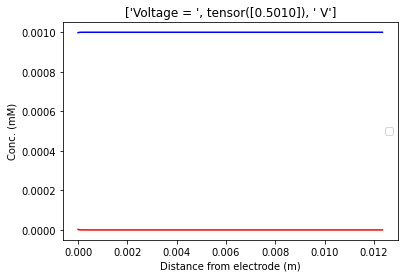

0 tensor([0.5010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


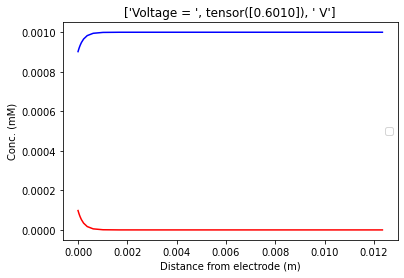

100 tensor([0.6010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


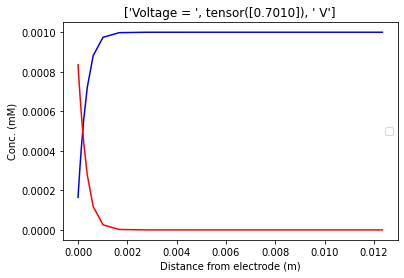

200 tensor([0.7010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


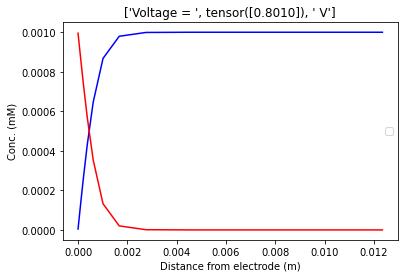

300 tensor([0.8010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


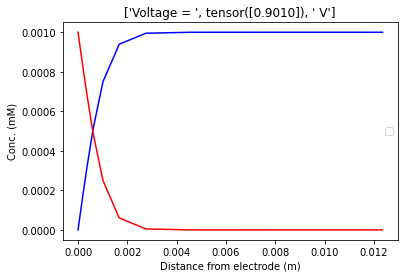

400 tensor([0.9010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


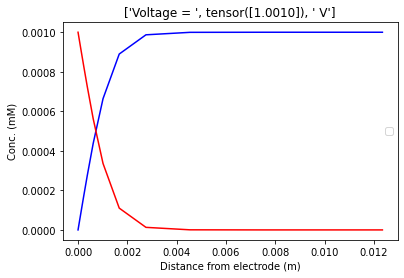

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


500 tensor([1.0010])


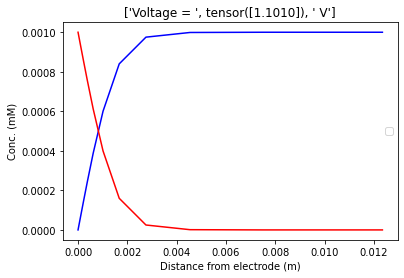

600 tensor([1.1010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


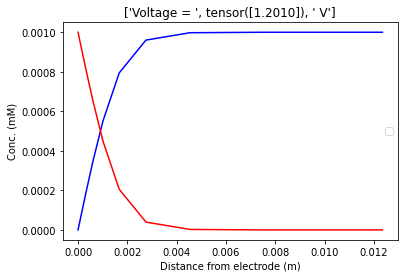

700 tensor([1.2010])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


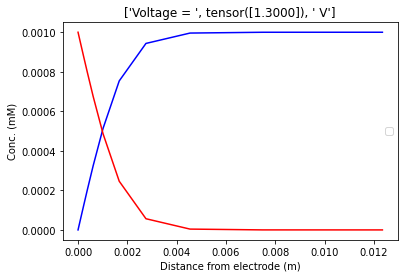

800 tensor([1.3000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


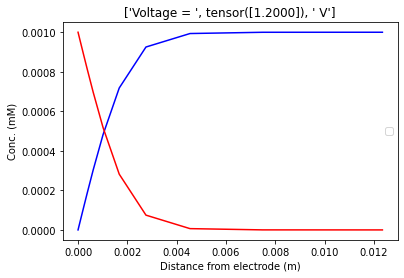

900 tensor([1.2000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


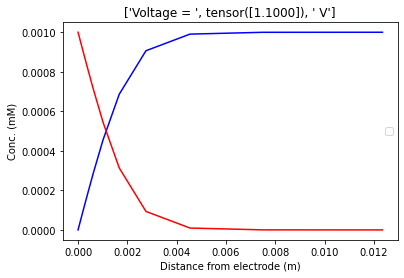

1000 tensor([1.1000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


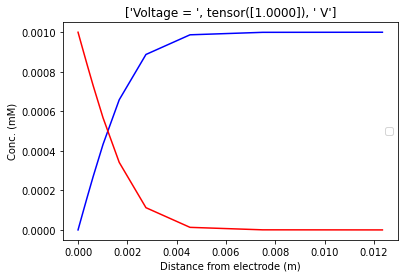

1100 tensor([1.0000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


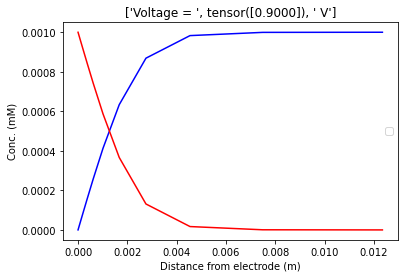

1200 tensor([0.9000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


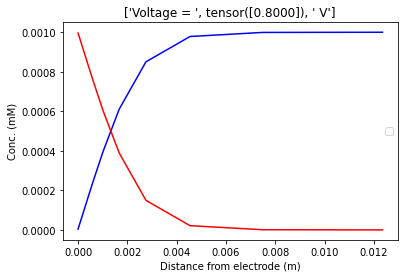

1300 tensor([0.8000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


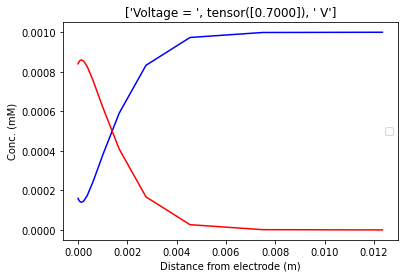

1400 tensor([0.7000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


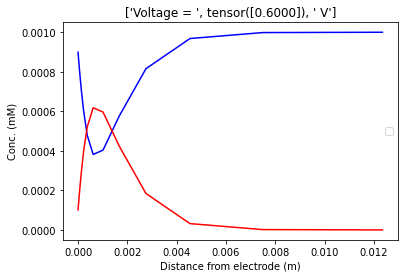

1500 tensor([0.6000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


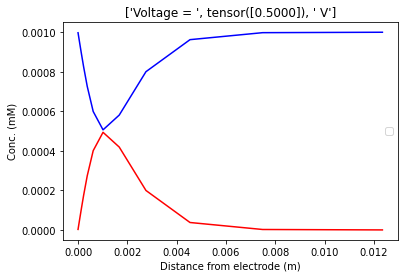

1600 tensor([0.5000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


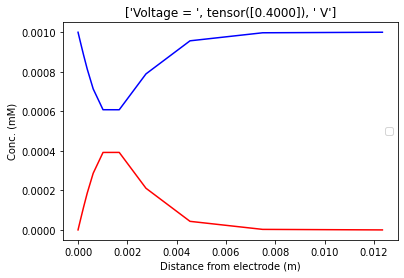

1700 tensor([0.4000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


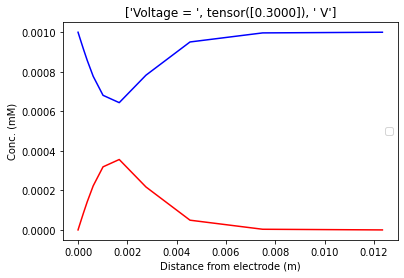

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


1800 tensor([0.3000])


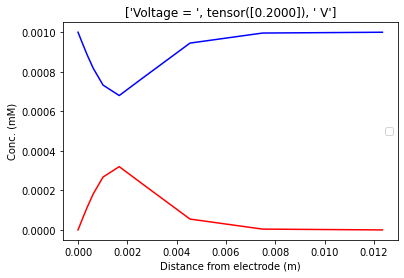

1900 tensor([0.2000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


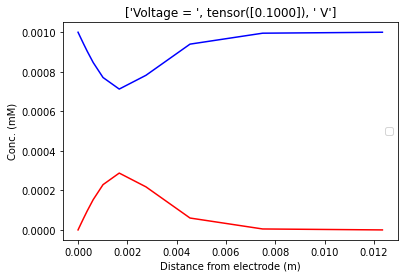

2000 tensor([0.1000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


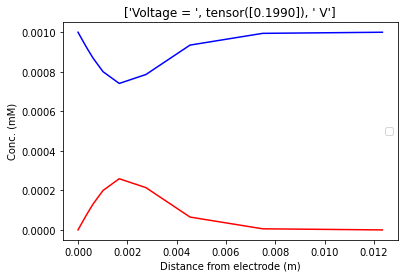

2100 tensor([0.1990])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


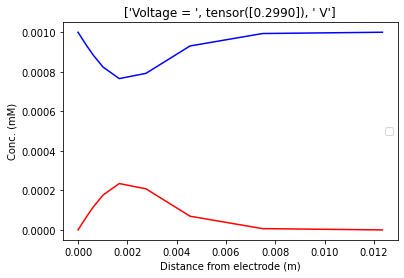

2200 tensor([0.2990])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


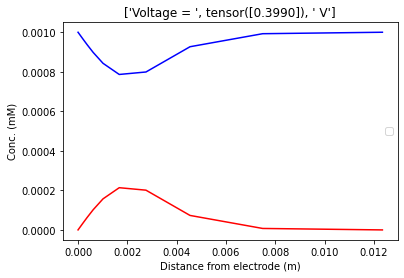

2300 tensor([0.3990])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


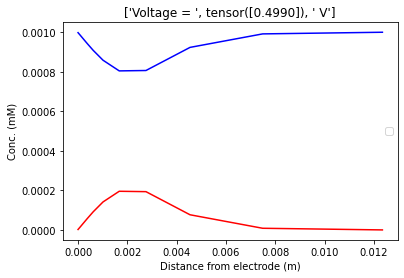

2400 tensor([0.4990])


In [ ]:
for E in Evt:
  kef = ks * math.exp((E-E0)*VT) * dx1 / DR
  keb = ks * math.exp(-(E-E0)*VT) * dx1 / DP
  
  #set values for row 0
  Dopt[0] = 0
  Dopt[0, 0] = 1 + kef
  Dopt[0, 1] = -1
  Dopt[0, N+1] = - keb

  Cold[0] = 0
  Cold[N] = CR0
  Cold[N+1] = 0
  Cold[2*N+1] = CP0

  Cnew, LU = torch.solve(Cold, Dopt)

  Istor[count,:] = DR*(Cnew[1] - Cnew[0])/dx1

  #plot the current profile every 100 mV increment of potential
  if count % 100 == 0:
         plt.figure(count)
         plt.plot(x[0:(N+1)],Cnew[0:(N+1)],'-b')
         plt.plot(x[(N+1)::],Cnew[(N+1)::],'-r')
         plt.title(['Voltage = ',E,' V'])
         plt.ylabel('Conc. (mM)')
         plt.xlabel('Distance from electrode (m)')
         plt.legend((1,2),('Reactant','Product'),loc=5)
         plt.show()
         print(count,E)
  count = count + 1
  Cold = Cnew

In [ ]:
Cnew_test, LU = torch.solve(Cold, Dopt)
print(torch.dist(Cold.double(), torch.mm(Dopt.double(),Cnew_test.double())))

tensor(2.5109e-06, dtype=torch.float64)


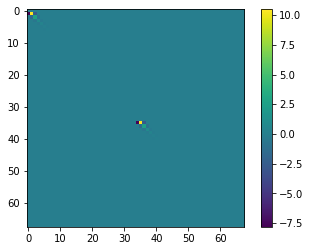

In [ ]:
plt.imshow((Dopt/(1e9)).tolist())
plt.colorbar()

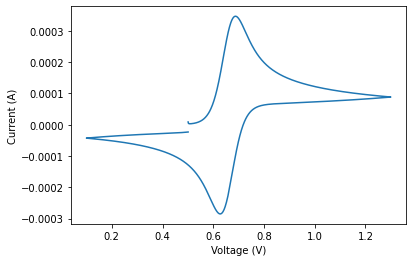

In [ ]:
plt.figure(2)
Istor = Istor * F  
plt.plot(Evt,Istor)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

In [ ]:
Evt_tensor = Evt.view(-1)
Istor_tensor = Istor.view(-1)
#Istor_tensor[Evt_tensor.le(2.0)] = 0
max_val, max_idx = Istor_tensor.max(0)
min_val, min_idx = Istor_tensor.min(0)
print ('max Evt', Evt_tensor[max_idx], 'max Istor', Istor_tensor[max_idx])
print ('min Evt', Evt_tensor[min_idx], 'min Istor', Istor_tensor[min_idx])

max Evt tensor(0.6880) max Istor tensor(0.0003, dtype=torch.float64)
min Evt tensor(0.6270) min Istor tensor(-0.0003, dtype=torch.float64)
